In [1]:
import os, sys, inspect
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# add parent dir to system dir
currdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootdir = os.path.dirname(currdir)
sys.path.insert(0, rootdir)

from airpollutionpy.utils import parse_datetime
from airpollutionpy.utils import series_to_supervised

Using TensorFlow backend.


In [2]:
# load data
fname = "PRSA_data_2010.1.1-2014.12.31.csv"
ffname = os.path.join(rootdir, "airpollutionpy", "data", "ext", fname)
data = pd.read_csv(ffname, parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse_datetime)

In [3]:
# clean data
data.drop("No", axis=1, inplace=True)
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
data.index.name = 'date'
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
# summarize first 5 rows
print(data.head(5))
# save to file
ffname = os.path.join(rootdir, "airpollutionpy", "data", "int", "pollution.csv")
data.to_csv(ffname)

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


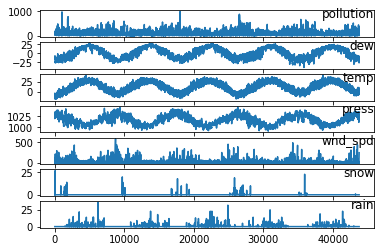

In [4]:
# plot trends
# load data
data = pd.read_csv(ffname, header=0, index_col=0)
values = data.values
n_data, n_variables = data.shape
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [5]:
index_target = 0
# set model parameters
n_lags = 24
n_sequences = 5
n_train = 365 * 24
n_units = 100

# set train parameters
optimizer = "adam"
loss = "mse"
n_epochs = 50
sz_batch = 72
verbose = 1

In [6]:
# pre-process data
# encode wind direction with value of the range [0:7]
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# call all data types to float
values = values.astype('float32')
# normalize variables to [0, 1]
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = minmax_scaler.fit_transform(values)
# reframe sequential data as supervised learning probelm
reframed_df = series_to_supervised(values_scaled, n_lags, n_sequences)
# print(reframed_df.head())

In [7]:
# create train/valid data
# split into train and test sets
values = reframed_df.values
train_values, valid_values = values[:n_train, :], values[n_train:, :]

In [8]:
# split into train and test sets
values = reframed_df.values
train_values, valid_values = values[:n_train, :], values[n_train:, :]

In [9]:
# split into input and targets
n_train = train_values.shape[0]
n_valid = valid_values.shape[0]
n_observations = n_lags * n_variables
x_train, y_train = train_values[:, :n_observations], train_values[:, n_observations+index_target:n_train:n_variables]
x_valid, y_valid = valid_values[:, :n_observations], valid_values[:, n_observations+index_target:n_valid:n_variables]
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (8760, 192), Train Targets Shape: (8760, 5)
Valid Inputs Shape: (35012, 192), Valid Targets Shape: (35012, 5)


Train Inputs Shape: (8760, 24, 8), Train Targets Shape: (8760, 5)
Valid Inputs Shape: (35012, 24, 8), Valid Targets Shape: (35012, 5)


In [11]:
# build model
model = Sequential()
model.add(LSTM(n_units, input_shape=(n_lags, n_variables)))
model.add(Dense(n_sequences))
model.compile(loss=loss, optimizer=optimizer)

In [12]:
# train model
history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=sz_batch,
                    validation_data=(x_valid, y_valid),
                    verbose=verbose,
                    shuffle=False)

Train on 8760 samples, validate on 35012 samples
Epoch 1/50
8760/8760 [==============================] - 6s 643us/step - loss: 0.0066 - val_loss: 0.0071
Epoch 2/50
8760/8760 [==============================] - 5s 623us/step - loss: 0.0038 - val_loss: 0.0055
Epoch 3/50
8760/8760 [==============================] - 5s 602us/step - loss: 0.0033 - val_loss: 0.0050
Epoch 4/50
8760/8760 [==============================] - 5s 585us/step - loss: 0.0031 - val_loss: 0.0049
Epoch 5/50
8760/8760 [==============================] - 5s 587us/step - loss: 0.0029 - val_loss: 0.0048
Epoch 6/50
8760/8760 [==============================] - 5s 593us/step - loss: 0.0027 - val_loss: 0.0047
Epoch 7/50
8760/8760 [==============================] - 5s 581us/step - loss: 0.0026 - val_loss: 0.0045
Epoch 8/50
8760/8760 [==============================] - 6s 631us/step - loss: 0.0025 - val_loss: 0.0041
Epoch 9/50
8760/8760 [==============================] - 6s 653us/step - loss: 0.0024 - val_loss: 0.0038
Epoch 10/50
876

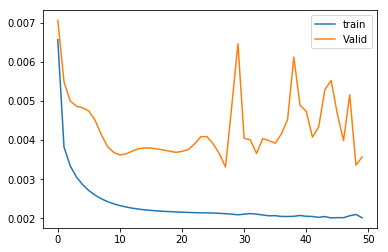

In [18]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Valid')
plt.legend()
plt.show()

In [19]:
# make a prediction
yhat_valid = model.predict(x_valid)
yhat_valid.shape

(35012, 5)

In [20]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_valid, yhat_valid))

In [21]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.060


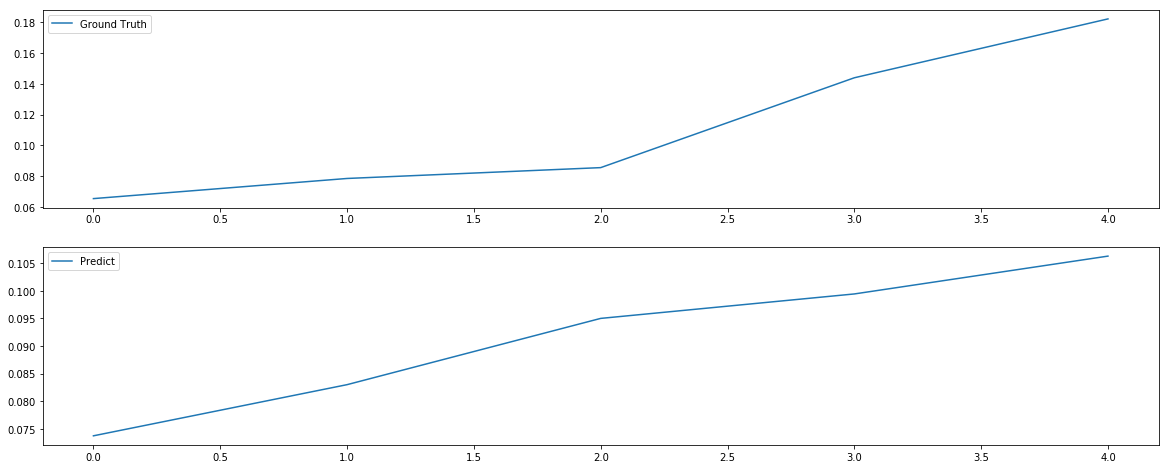

In [22]:
figsize = (20, 8)
fig = plt.figure(figsize=figsize)
ax = fig.subplots(2, 1)
ax[0].plot(np.arange(0, y_valid.shape[1]), y_valid[0, :], label="Ground Truth")
ax[0].legend()
ax[1].plot(np.arange(0, y_valid.shape[1]), yhat_valid[0, :], label="Predict")
ax[1].legend()

